# Project 3: Text Classification with Naive Bayes
<b> By: </b> Kevin Nguyen (50351461) for MTH 448
<br>
<b> Created: </b> April 5, 2023
<br>
<b> Last Updated: </b> April 23, 2023

## Introduction

Text classification is an important machine learning technique with applications in diverse areas, including (but not limited to): making business decisions by analyzing customer reviews, inferring/predicting a government's intents based on their speech or posts, and detecting spam e-mails. To make use of text classification, groups typically obtain a data set containing text as well as one or more categories that each text falls into. For example, a business interested in improving one of their products could obtain all the reviews for that product, where each review has a star rating associated with it.

Most text classification algorithms are supervised, meaning they use labeled training/test data. Unsupervised algorithms for text classification do exist, but our focus in this project will be the Naive Bayes Classifier, a supervised technique.<sup>1</sup>

We will dive deeper into Naive Bayes before we implement it, but in short it is a probabilistic model driven by Bayes' Theorem<sup>2</sup>:

$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$$

In the context of text classification, let $A$ be a possible category for some text and let $B = (b_1, b_2, b_3, \dots, b_n)$ be the set of predictors in that text. We can then restate Bayes' Theorem as the probability that a piece of text is in category $y$, given that it has features $b_1, b_2, b_3, \dots, b_n$, on the assumption that $A$ and $B$ are independent of each other. To be "independent of each other" means that any two features $b_i$ and $b_j$ do not affect each other's chances of occurring. This assumption is also where the "naive" part comes from.


### Project Goals
For this project, we will be implementing a variation of Naive Bayes: the multinomial Naive Bayes, which is useful when the features are word counts in a data set. To test and analyze the effectiveness of this model, we will use it on two datasets: movie reviews that have been labeled as positive or negative to predict whether a new review is positive or negative, and posts from newsgroups to predict which newsgroup a new post is from.

The dataset of movie reviews is already somewhat processed: it comes as a ```.csv``` where each row contains a review and its corresponding rating. On the other hand, the dataset of newsgroup posts is entirely raw: it comes as a ```.txt``` file containing every post and corresponding information about the post (which newsgroup the post is from, the author, and the subject), so some processing must be done there to shape the dataset into a table where each row contains a post and corresponding newsgroup.

In either case, the text in each dataset needs to be processed, as they need to be normalized for the best classification results.<sup>6</sup>

### Preliminary Steps

In this section, we will be performing the steps necessary to start classifying text data, but first, we will import the necessary libraries for the entire project, which will mainly be ```pandas``` for reading and working with the data, ```regex``` for cleaning the data using regular expressions, and ```sklearn``` modules for model testing.

Then, we will need to clean the text data. In this context, "cleaning" the data will involve removing any irrelevant text and making each entry have the same format. So for example, we will be making the text lower-cased, removing any HTML tags and newline characters, and removing other non-words such as punctuation and numbers.

This is an essential step for classifying text data (and cleaning is essential, in general, for working with any kind of data), because it standardizes the text, makes it easy to break down into its unique words, and reduces variation in text, which help to define it as being of a certain category.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from tqdm import tqdm

# Display full columns instead of truncating
pd.set_option('display.max_colwidth', None)

### Loading and Cleaning the Text

In general, it is not guaranteed that each dataset containing text has the same text formatting. This is especially true in unstructured data such as forum posts and movie reviews. Therefore, we will need to take a look at each dataset individually to better understand what steps need to be taken to produce a clean text.

#### Movie Reviews

In [2]:
# Load initial data set of movie reviews
movie_reviews = pd.read_csv("text\movie_reviews.zip")

train_movies, test_movies = train_test_split(movie_reviews, train_size = 0.80, random_state = 21041)

# Look at some reviews to see what needs to be cleaned in reviews
movie_reviews.head(3)

,review,sentiment
0,"This film is absolutely awful, but nevertheless, it can be hilarious at times, although this humor is entirely unintentional.<br /><br />The plot was beyond ridiculous. I don't even think a 2 year-old would be convinced by the ludicrous idiocy that the film-makers tried to slap together into a story. However, on the positive side, some of the horrifically inane plot twists provide a great deal of humor. For example, ""Wow, Lady Hogbottom has a giant missile hidden in her back yard!"" It gets worse (and even funnier), but I'll spare you.<br /><br />The acting is generally laughable. Most of the kids' roles are sort of cute, but not very believable. On the other hand, Annie is pretty awful all-around. The adults don't take their roles seriously at all, but this is largely a good thing. If they'd tried to be believable, the film would've been even worse. Which is difficult to imagine.<br /><br />Once you get past the overall crappiness of the movie, there are actually a few standout moments of almost-not-crappiness. The scene where Lady Hogbottom's son runs away with the maid is surprisingly hilarious, though it's an annoying letdown when they get caught by the police. The butler character, while very minor, is a ray of sunlight that almost, but never quite pierces through the gloom.<br /><br />Watching this movie actually caused me physical pain. Nevertheless, there were a few redeeming parts that made it almost watchable without beginning to hemorrhage internally. Judged on its good parts alone, the movie would be about a 5; unfortunately, the rest of the movie hardly deserves a 1. Thus, I give it a 3.<br /><br />That's being pretty generous, I'd say.",negative
1,"Well since seeing part's 1 through 3 I can honestly say that they should have NEVER made part 4. Everything from the tacky, and I DO mean tacky score to the really bad acting, I dare anyone to watch this and not be bored out of their minds.<br /><br />I mean parts 1 to 3 kept the vibe strong on the plot of Damion, but without him around in this one it's just not the same. Sure by the end of part 3 I was getting a little tired of the continued story line's, but it was a good closure at the end of the third one. Again there was no reason for a part 4. Even if there was they could have done a MUCH better job than this sh*t I had to sit through, lol. There goes an hour and a half of my life i'll never see again.",negative
2,"I got to see this film at a preview and was dazzled by it. It's not the typical romantic comedy. I can't remember laughing so hard at a film and yet being moved by it. The laughs aren't gags here--they're observations, laughs of recognition, little shocks of ""Oh, my God, I thought I was the only one who felt that way!"" I won't give away the plot, which is more than just ""Guy falls in love with his brother's girlfriend."" The whole family plays a part in the relationship here. Probably the best blend of laughter and warmth since ""While You Were Sleeping."" <br /><br />Steve Carell goes much deeper than he's gone before, and for the first time I really liked him. The cast is amazing, a list of veteran theater actors whom I've loved in other roles, but they blend to make a convincing family. Dianne Wiest is lovely as the mother, Juliette Binoche is luminous and hilarious (who knew she was funny?), and even the reviled Dane Cook gives a warm, quiet, touching performance. The Sondre Lerche soundtrack is a wonderful addition, and I'll buy the CD the second it's available.<br /><br />Don't miss this one.",positive


In [222]:
movie_reviews.loc[movie_reviews["sentiment"] == "positive"].count()

review       12500
sentiment    12500
dtype: int64

From looking at these three reviews, it can be assumed that each review has the following characteristics:
* Punctutation
* Capitalization
* ```<br />``` (linebreak) tags
* Numbers

These are easy things to fix using regular expressions. To fix capitalization, we will simply make the entire text lowercase using Python's built-in ```str.lower()``` method.

To get rid of ```<br />``` tags, we will use a regular expression which matches ```<br />``` in the text, and replace it with an empty string.

To get rid of punctuation and numbers, we will use negative matching, specifically ```[^\w\s]``` which matches any character that is not a word or whitespace, to remove punctuation. In the exceptional case where not all digits are removed, we will use ```\d``` to find digits in the text and replace them with a space.

Both fixes will lead to uneven whitespace between words, so we will need to get rid of any whitespace using this regular expression: ```^\s+|\s+$|\s+(?=\s)```.

* ```^\s+``` matches whitespace at the beginning
* ```\s+$``` matches whitespace at the end.
* ```\s+(?=\s)``` is a positive lookahead that looks for whitespace bigger than 1 space.

In [3]:
def clean_movies(text, stopwords = []):
    """
    Returns a clean-formatted string given an input movie review string. All words from the input
    are made lowercase, punctuation removed, linebreak tags removed, and other non-words removed.
    
    Parameters:
    text <str>: Input string to clean and split into words
    stopwords <list[str], optional>: Defaults to an empty list. If a list of stopwords is passed,
    then stopwords in text will be removed as well.
    
    Returns: 
    cl_text <str>: Cleaned text string, with or without stopwords removed
    """
    
    cl_text = text.lower() # make text lowercase
    cl_text = re.sub(r"<br />", "", cl_text) # remove <br \> tags
    cl_text = re.sub(r"\'", "", cl_text) # remove apostrophes
    cl_text = re.sub(r"[^\w\s]", " ", cl_text) # remove other punctuation
    cl_text = re.sub(r"[\d-]", " ", cl_text) # remove numbers
    cl_text = re.sub(r"/^\s+|\s+$|\s+(?=\s)", "", cl_text) # remove trailing, leading whitespace between words

    words = cl_text.split(" ") # split text into list of words
    
    # if stopwords is empty list then return above, if list of stopwords is passed, return list of words without stopwords
    if len(stopwords) == 0:
        return cl_text
    elif len(stopwords) > 0:
        clean_words = [word for word in words if word not in sw]
        return " ".join(clean_words)

In [4]:
# load stopwords
sw = open("text\stopwords.txt", "r").read().split(",")

In [5]:
# apply cleaning to text, split into words, and add as new column
train_movies["cleaned_words"] = train_movies["review"].apply(clean_movies, stopwords = sw).str.split()

In [6]:
train_movies.head(1)

,review,sentiment,cleaned_words
19394,"The only time I have seen this movie was when I was 10 years old. I have remembered it all of these years as I couldn't sleep for a week or more after seeing it. It just absolutely rattled me. I was on vacation with my aunts in Ft. Worth, Texas and I will never forget it. Now, 48 years later, my daughter is trying to get a copy of this for me to view as an adult. It has taken a lot of research to find out what movie it was but I always remembered that Barbara Stanwyck was in it and finally was able to get the name and reviews on it. I very much enjoyed it, but it gave me quite a scare! Jaqui",positive,"[time, seen, movie, years, old, remembered, years, couldnt, sleep, week, more, seeing, absolutely, rattled, vacation, aunts, ft, worth, texas, never, forget, now, years, later, daughter, trying, copy, view, adult, taken, lot, research, find, out, movie, always, remembered, barbara, stanwyck, finally, name, reviews, very, much, enjoyed, gave, quite, scare, jaqui]"


#### Newsgroups

The text data for the newsgroups is found inside a ```.txt``` file, instead of a ```.csv``` file as the movie reviews were found in. When we read in this file, it is going to be one string, so this means we will have to do some extra parsing of the file to get the name of the newsgroup and the content of the post.

Importantly, when we parse the file and separate each post out, we are going to filter out any "incomplete" entries, i.e. any entries that may be missing a newsgroup, author, and/or subject. Although it may not be a best practice to filter these entries out, a complete dataset is more valuable for the sake of text classification than an incomplete one, especially in the case where a newsgroup entry is missing as we are trying to predict the newsgroup of a post.

In [7]:
# read in newsgroup text
with open("text/newsgroups.txt", encoding = "utf8") as f:
    txt = f.read()

In [8]:
# printing the entire txt is dangerous - print a slice
txt[:2000]

'Newsgroup: rec.autos\nFrom: gwm@spl1.spl.loral.com (Gary W. Mahan)\nSubject: Re: Are BMW\'s worth the price?            \n\n\n>sure sounds like they got a ringer.  the 325is i drove was definitely\n>faster than that.  if you want to quote numbers, my AW AutoFile shows\n>0-60 in 7.4, 1/4 mile in 15.9.  it quotes Car and Driver\'s figures\n>of 6.9 and 15.3.  oh, BTW, these numbers are for the 325i.\n\nCar and Driver rated the 325is (1988) at 7.2 0-60 , 1/4 at 15.2 (after 30k miles) last time I checked 8#}.\n\nAutomobile magazine rated new 325is 1/4 mile@16.2.\n\nGee , aint quotiin funner than the dickens!\n\nSounds like we need a race.  I\'ll let you have the newer version.  Can someone out there lend me a 1988 325is for a day 8-].  I wont hurt it, I promise.\n\n>i don\'t know how the addition of variable valve timing for 1993 affects it.\n>but don\'t take my word for it.  go drive it.\n\nActually I will take your word on it.  I refuse to test it (new 325is) because\nI love BMW\'s and w

From the above slice of the text, we can see that each post is structured in a specific way:

Newsgroup: ...
<br>
From: ...
<br>
Subject: ...


Text1

So if we want to break down the text and separate out the information, we should use a regular expression like before.

In this case, we want to split the string wherever we see the combination "Newsgroup", "From", and "Subject".

The desired regular expression to accomplish this is:

```Newsgroup:\s*(.*)\s*From:\s*(.*)\s*Subject:\s(.*)\n```

For the most part, what this expression matches should be clear, but each part has a ```(.*)``` which captures the text that comes after "Newsgroup: ", "From: ", and "Subject: ".

Using ```re.split```, we can split the text wherever we see one of these three things.

As previously mentioned, for each occurrence of a match the function will split and in the end, return:
* The text that comes after "Newsgroup: "
* The text that comes after "From: "
* The text that comes after "Subject: "
* The remaining text - in other words the content of the post.

In [9]:
# Regex magic that splits the text wherever it matches with: Newsgroup, From, or Subject.
# info be grouped by 4s: (newsgroup info, from info, subject info, and remaining info)

split_info = re.split(r"Newsgroup:\s*(.*)\s*From:\s*(.*)\s*Subject:\s(.*)\n", txt)[1:]

# look at structure of split_info to extract newsgroup and text only
# uncomment below to check

# split_info[:12]

In [10]:
# newsgroup names are in indices [0, 4, 8, ...]
# posts are in indices [3, 7, 11, ...]
names = [split_info[k] for k in range(len(split_info)) if k % 4 == 0]
posts = [split_info[k] for k in range(len(split_info)) if k % 4 == 3]

# data check
print(f"{len(names) == len(posts)}: Lengths match")
print(f"{posts[0] == split_info[3]}: First post of posts is same as first post of split_info")
print(f"{posts[1] == split_info[7]}: Second post of posts is same as second post of split_info")

True: Lengths match
True: First post of posts is same as first post of split_info
True: Second post of posts is same as second post of split_info


In [11]:
# create df with desired info
newsgroup_df = pd.DataFrame({"newsgroup": names, "post": posts})
newsgroup_df.head()

,newsgroup,post
0,rec.autos,"\n\n>sure sounds like they got a ringer. the 325is i drove was definitely\n>faster than that. if you want to quote numbers, my AW AutoFile shows\n>0-60 in 7.4, 1/4 mile in 15.9. it quotes Car and Driver's figures\n>of 6.9 and 15.3. oh, BTW, these numbers are for the 325i.\n\nCar and Driver rated the 325is (1988) at 7.2 0-60 , 1/4 at 15.2 (after 30k miles) last time I checked 8#}.\n\nAutomobile magazine rated new 325is 1/4 mile@16.2.\n\nGee , aint quotiin funner than the dickens!\n\nSounds like we need a race. I'll let you have the newer version. Can someone out there lend me a 1988 325is for a day 8-]. I wont hurt it, I promise.\n\n>i don't know how the addition of variable valve timing for 1993 affects it.\n>but don't take my word for it. go drive it.\n\nActually I will take your word on it. I refuse to test it (new 325is) because\nI love BMW's and would probably want to buy it. Problem is, my income just doesn't support that. \n\n\n"
1,sci.med,"\n\nI have been hearing bad thing about amalgam dental fillings. Some say\nthe lead/ mercury leeches into your system and this is bad. And I have\nrecently heard that there is some suspicion that the mercury is a breeding\nground for bacteria that will be resistant to antibiotics. \n\nMy dentist wants to use an amalgam filling for me in a place where I have\ntwo cavaties in one tooth and wants to use one filling to cover both.\nHe says that composite filling don't hold up well when they are large.\nSo, I would like to know if there are any other choices besides amalgam\nand composite. And, should I really even be worried about amalgam? I\nheard that some scandanavian country does not even use them any more- \nis this true.\n\nAny information you can give me will be greatly appreciated.\n\n\nThanks!\n\nDave Childs\n\n\n\n"
2,alt.atheism,"\n\n>DATE: Tue, 6 Apr 1993 00:11:49 GMT\n>FROM: F. Karner <karner@austin.ibm.com>\n>\n>In article <1993Apr2.103237.4627@Cadence.COM>, mas@Cadence.COM (Masud Khan) writes:\n>> In article <C4qAv2.24wG@austin.ibm.com> karner@austin.ibm.com (F. Karner) writes:\n>> >\n>> >Okay. So you want me to name names? There are obviously no official\n>> >records of these pseudo-marriages because they are performed for\n>> >convenience. What happens typically is that the woman is willing to move\n>> >in with her lover without any scruples or legal contracts to speak of. \n>> >The man is merely utilizing a loophole by entering into a temporary\n>> >religious ""marriage"" contract in order to have sex. Nobody complains,\n>> >nobody cares, nobody needs to know.\n>> >\n>> >Perhaps you should alert your imam. It could be that this practice is\n>> >far more widespread than you may think. Or maybe it takes 4 muslim men\n>> >to witness the penetration to decide if the practice exists!\n>> >-- \n>> >\n>> \n>> Again you astound me with the level of ignorance you display, Muslims\n>> are NOT allowed to enter temporary marriages, got that? There is\n>> no evidence for it it an outlawed practise so get your facts \n>> straight buddy. Give me references for it or just tell everyone you\n>> were lying. It is not a widespread as you may think (fantasise) in\n>> fact contrary to your fantasies it is not practised at all amongst\n>> Muslims.\n\nDid you miss my post on this topic with the quote from The Indonesian\nHandbook and Fred Rice's comments about temporary marriages? If so, \nI will be glad to repost them. Will you accept that it just may be \na practice among some Muslims, if I do? Or will you continue to claim\nthat we are all lying and that it is ""not practised at all amongst Muslims"".\n\nI don't think F. Karner has to tell everyone anything. Least of all that\nhe is lying.\n\nSince you obviously know nothing about this practice, there is very little\nyou can contribute to the discussion except to accuse everyone of lying.\nPerhaps it is your ignorance which is showing. Learn more about Islam.\nLearn more about Muslims. Open your eyes. Maybe you 

Now that we have successfully parsed the text and created a dataframe with the columns we need, the next step is to do as before and clean the text.

During our process of parsing the text, we have been able to get a good look of the structure of each text.

Luckily, each post seems to be formatted similarly to the movie reviews, at least in terms of HTML tags and non-words, which saves a lot of time: we can copy and paste most of the code from the previous function, but with some changes. Instead of ```<br />``` tags, these posts use ```\n``` characters, so we will have to make that adjustment to get rid of those.

In [188]:
def clean_post_text(text, stopwords = []):
    """
    Returns a clean-formatted string given an input forum string. All words from the input are made
    lowercase, punctuation removed, and new line tags removed, and other non-words removed.
    
    Parameters:
    text <str>: Input string to clean and split into words
    stopwords <list[str], optional>: Defaults to an empty list. If a list of stopwords is passed,
    then stopwords in text will be removed as well.
    
    Returns: 
    cl_text <str>: Cleaned text string, with or without stopwords removed.
    """
    
    cl_text = text.lower() # make text lowercase
    cl_text = re.sub(r"'", "", cl_text) # remove apostrophes
    cl_text = re.sub(r"[^\w\s]", " ", cl_text) # remove punctuation    
    cl_text = re.sub(r"[\d-]", "", cl_text) # remove numbers
    cl_text = re.sub(r"\n", " ", cl_text) # remove leftover \n tags
    cl_text = re.sub(r"/^\s+|\s+$|\s+(?=\s)", "", cl_text) # remove trailing, leading whitespace between words
    cl_text = cl_text.replace("writes", "")
    cl_text = cl_text.replace("com", "")
    cl_text = cl_text.replace("edu", "")
    cl_text = cl_text.replace("org", "")
    cl_text = cl_text.replace("article", "")
    cl_text = cl_text.replace("_", "")

    words = cl_text.split(" ") # split cleaned text into list of words
    
    # if stopwords is empty list then return above, if list of stopwords is passed, return list of words without stopwords
    if len(stopwords) == 0:
        return cl_text
    elif len(stopwords) > 0:
        clean_words = [word for word in words if word not in sw]
        return " ".join(clean_words)

In [189]:
# apply cleaning function to posts, split into words and add as new column in df
clean_text = newsgroup_df["post"].apply(clean_post_text, stopwords = sw)
newsgroup_df["cleaned_words"] = clean_text.str.split()

In [190]:
newsgroup_df.head()

,newsgroup,post,cleaned_words
0,rec.autos,"\n\n>sure sounds like they got a ringer. the 325is i drove was definitely\n>faster than that. if you want to quote numbers, my AW AutoFile shows\n>0-60 in 7.4, 1/4 mile in 15.9. it quotes Car and Driver's figures\n>of 6.9 and 15.3. oh, BTW, these numbers are for the 325i.\n\nCar and Driver rated the 325is (1988) at 7.2 0-60 , 1/4 at 15.2 (after 30k miles) last time I checked 8#}.\n\nAutomobile magazine rated new 325is 1/4 mile@16.2.\n\nGee , aint quotiin funner than the dickens!\n\nSounds like we need a race. I'll let you have the newer version. Can someone out there lend me a 1988 325is for a day 8-]. I wont hurt it, I promise.\n\n>i don't know how the addition of variable valve timing for 1993 affects it.\n>but don't take my word for it. go drive it.\n\nActually I will take your word on it. I refuse to test it (new 325is) because\nI love BMW's and would probably want to buy it. Problem is, my income just doesn't support that. \n\n\n","[sure, sounds, ringer, drove, definitely, faster, want, quote, numbers, aw, autofile, shows, mile, quotes, car, drivers, figures, oh, btw, numbers, car, driver, rated, k, miles, last, time, checked, automobile, magazine, rated, new, mile, gee, aint, quotiin, funner, dickens, sounds, need, race, ill, newer, version, someone, out, lend, day, wont, hurt, promise, dont, know, addition, variable, valve, timing, affects, dont, take, word, go, drive, actually, take, word, refuse, test, new, love, bmws, probably, want, buy, problem, ine, doesnt, support]"
1,sci.med,"\n\nI have been hearing bad thing about amalgam dental fillings. Some say\nthe lead/ mercury leeches into your system and this is bad. And I have\nrecently heard that there is some suspicion that the mercury is a breeding\nground for bacteria that will be resistant to antibiotics. \n\nMy dentist wants to use an amalgam filling for me in a place where I have\ntwo cavaties in one tooth and wants to use one filling to cover both.\nHe says that composite filling don't hold up well when they are large.\nSo, I would like to know if there are any other choices besides amalgam\nand composite. And, should I really even be worried about amalgam? I\nheard that some scandanavian country does not even use them any more- \nis this true.\n\nAny information you can give me will be greatly appreciated.\n\n\nThanks!\n\nDave Childs\n\n\n\n","[hearing, bad, thing, amalgam, dental, fillings, lead, mercury, leeches, system, bad, recently, heard, suspicion, mercury, breeding, ground, bacteria, resistant, antibiotics, dentist, use, amalgam, filling, place, two, cavaties, one, tooth, use, one, filling, cover, both, posite, filling, dont, hold, up, well, large, know, choices, besides, amalgam, posite, really, even, worried, amalgam, heard, scandanavian, country, even, use, more, true, information, give, greatly, appreciated, thanks, dave, childs]"
2,alt.atheism,"\n\n>DATE: Tue, 6 Apr 1993 00:11:49 GMT\n>FROM: F. Karner <karner@austin.ibm.com>\n>\n>In article <1993Apr2.103237.4627@Cadence.COM>, mas@Cadence.COM (Masud Khan) writes:\n>> In article <C4qAv2.24wG@austin.ibm.com> karner@austin.ibm.com (F. Karner) writes:\n>> >\n>> >Okay. So you want me to name names? There are obviously no official\n>> >records of these pseudo-marriages because they are performed for\n>> >convenience. What happens typically is that the woman is willing to move\n>> >in with her lover without any scruples or legal contracts to speak of. \n>> >The man is merely utilizing a loophole by entering into a temporary\n>> >religious ""marriage"" contract in order to have sex. Nobody complains,\n>> >nobody cares, nobody needs to know.\n>> >\n>> >Perhaps you should alert your imam. It could be that this practice is\n>> >far more widespread than you may think. Or maybe it takes 4 muslim men\n>> >to witness the penetration to decide if the practice exists!\n>> >-- \n>> >\n>> \n>> Again you astound me with the level of ignorance you display, Muslims\n>> are NOT a

In [191]:
# get newsgroup names - should have 8
newsgroup_names = newsgroup_df.newsgroup.unique()
newsgroup_names

array(['rec.autos', 'sci.med', 'alt.atheism', 'rec.sport.baseball',
       'talk.religion.misc', 'rec.sport.hockey', 'sci.electronics',
       'rec.motorcycles'], dtype=object)

In [235]:
# split into train and test sets
train_news, test_news = train_test_split(newsgroup_df, train_size = 0.8, random_state = 21041)

## Implementing Naive Bayes Classifier

Now that we have successfully processed and cleaned both of the datasets we will be working with, our next step is to actually implement Naive Bayes.

As was mentioned in the Introduction, what drives Naive Bayes is Bayes' Theorem, $P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$, and we will be using Multinomial Naive Bayes, instead of the standard Gaussian Naive Bayes.<sup>3</sup> The main difference is that Multinomial Naive Bayes assumes a multinomial distribution of data (which, in this context is how often a word appears in a particular category) and Gaussian Naive Bayes assumes a Gaussian (or normal) distribution of data.

We will also be doing additional modifications:
* Laplace smoothing,<sup>7</sup> which ensures we do not get any zero probabilities.
    * There are two cases where we can get a zero probability: the word is not present in one or more of the categories, or the word is completely unknown. We only have to check for the latter case, and if it is true we initialize an array of $0$ to represent the word.
    * When the probability is calculated, we are going to add $1$ to the count of the word and then divide by the total number of words in each category plus the number of unique words.
        * Why add the number of unique words to the denominator: since we are essentially adding $1$ to each word's count that we encounter, the number of words in each category has increased by the number of unique words.
* Taking the log probability. Since we are dealing with probabilities, which are bounded between $0$ and $1$, a problem of underflow may occur because decimals are stored using 64-bits. This means that a very small decimal may be incorrectly represented as $0$. By applying $\ln$ to each probability, we ensure underflow doesn't happen by mapping the probability to $\left(-\infty,0\right]$ as the log of a small, positive decimal is a large, negative number.
    * The natural log preserves order. If $P(A) < P(B)$ then it's also true that $\ln P(A) < \ln P(B)$

In [236]:
# get word counts in movie reviews
word_counts_movies = {} # container for word counts

# iterate through each row in the df
for row in train_movies.itertuples():
    sentiment = row.sentiment # store current row's sentiment
    # iterate through each word in current row's list of words
    for word in row.cleaned_words:
        # check if word is already present in word counter
        if word not in word_counts_movies:
            word_counts_movies[word] = {"positive": 0, "negative": 0} # if not, initialize as dictionary of 0
        # add 1 to the word counter for corresponding sentiment
        word_counts_movies.get(word)[sentiment] += 1

# create dataframe from word counts
wc_movies = pd.DataFrame.from_dict(word_counts_movies, orient='index')
wc_movies = wc_movies[['positive', 'negative']]

In [237]:
# get word counts in newsgroup posts
# code is same as for movies, adapted for newsgroups
word_counts_newsgroups = {}
for row in train_news.itertuples():
    ng = row.newsgroup
    for word in row.cleaned_words:
        if word not in word_counts_newsgroups:
            word_counts_newsgroups[word] = {
                'rec.autos': 0, 'sci.med': 0, 'alt.atheism': 0,
                'rec.sport.baseball': 0, 'talk.religion.misc': 0,
                'rec.sport.hockey': 0, 'sci.electronics': 0,
                'rec.motorcycles': 0
            }
        word_counts_newsgroups.get(word)[ng] += 1
        
wc_newsgroups = pd.DataFrame.from_dict(word_counts_newsgroups, orient='index')
wc_newsgroups = wc_newsgroups[['rec.autos', 'sci.med', 'alt.atheism', 'rec.sport.baseball',
                               'talk.religion.misc', 'rec.sport.hockey', 'sci.electronics',
                               'rec.motorcycles']]

In [238]:
def NB_classifier(text, word_counts, stopwords = []):
    """
    Predicts the category that a piece of text belongs to, given a dataframe of word counts for each category.
    
    Parameters:
    text <str>: The text to be classified (should be cleaned already)
    word_counts <dataframe>: DataFrame where columns are the categories and each row is a unique word from the
                             training data set. Counts the appearance of each unique word, separated
                             by the category it appeared in.
                             
    Returns tuple(class, prod), where:
    class <str>: the class associated with the highest probability calculated.
    prod <numpy.ndarray[float]>: an array of log-probability values between negative infinity and 0
    """
    
    classes = list(word_counts.columns) # categories for the text 
    tot = np.array(word_counts.sum()).sum() # total number of words in training set across all categories
    prod = np.ones(len(classes)) # initialize array of 1s to store each classes' probability
    
    # iterate through the classes and get probability of that class
    for idx, category in enumerate(classes):
        prod[idx] = word_counts[f"{category}"].sum()/(tot)
    prod = np.log(prod) # take log probability
    
    words = text.split(" ") # split into list of words
    
    # iterate through the words in desired text
    for word in words:
    # check if the current word is present in our word counts, if not initialize it as an array of 0
        w = word_counts.loc[word] if word in word_counts.index else np.zeros(shape = len(classes))
        
        # calculate probability with laplace smoothing
        p = (w+1)/(word_counts.sum() + len(word_counts))
        
        # add the log of our result to the probability array
        prod += np.log(np.array(p))
    return (classes[np.argmax(prod)], prod)

## Testing and Analysis of Naive Bayes

Now that we have implemented Naive Bayes, we need to test its performance on the two datasets. The two performance metrics we want to measure are efficiency and accuracy.

To measure the accuracy of our classifier, we will be using ```scikit-learn```'s built-in ```f1_score``` method, which calculates the F1 score. The F1 score is defined as: 

$$\text{F1} = \frac{2PR}{P + R}$$

where $P$ (precision) is defined as the number of actual positives divided by the number of all positives, and $R$ (recall) is defined as the number of actual positives divided by the number of actual positives and false negatives.<sup>4</sup>

To measure the efficiency of our classifier, we will examine how long it takes for the model to train on varying training set sizes and we will perform a (simple) runtime analysis of our implementation and arrive at an asymptotic upper-bound on our implementation's runtime.

Besides performance, we also want to look at other parts of the data and the algorithm, including: the most frequent words in each class, what classes are misclassified more often than other categories for the newsgroup dataset, and how the training size impacts accuracy.

### Word Frequency
Before we dive any deeper into testing Naive Bayes, it will be worthwhile to examine the word counts, compare the frequency of words between classes, and obtain the top ten words for each category. Even though we removed stopwords, we expect for the movie reviews to have about the same top ten words in both categories, while the newsgroups should vary more between topics that are less related.

In [239]:
def plot_wc_hist(df, n, category, fig, plotspot):
    """
    Calculates top n words in a class and draws a histogram of these values within a figure's subplot.
    
    Parameters:
    df <dataframe>: DataFrame of word counts
    n <int>: Number of top words to find
    category <str>: A class label
    fig <matplotlib.Figure>: A figure for plotting the histogram
    plotspot <int>: Subplot position
    
    Returns:
    None
    """
    top_curr = df.nlargest(n, category)[category] # top n words of current category
    dim = "21" if df.shape[1] <= 2 else "42" # number of subplots as either 2 or 8
    fig.add_subplot(int(f"{dim}{plotspot}")) # adds a subplot to the fig at current plotspot
    plt.bar(x = list(top_curr.index), height = list(top_curr.values)) # creates bar graph of frequencies
    plt.title(f"{category}") # title of subplot
    plt.xlabel("Word") # x-axis label of subplot
    plt.ylabel('Count') # y-axis label of subplot
    
    return None

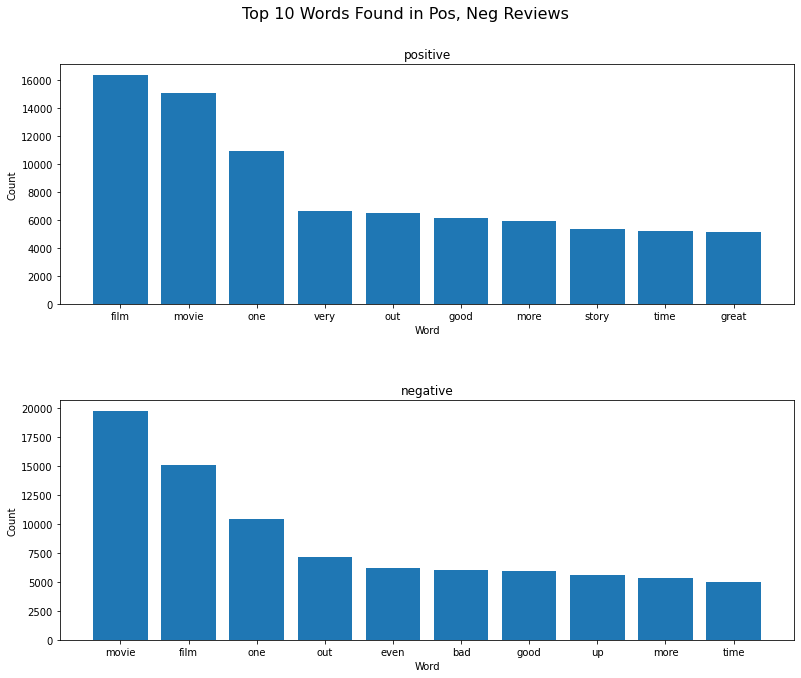

In [240]:
fig1 = plt.figure(figsize = (12, 10)) # create figure
fig1.suptitle("Top 10 Words Found in Pos, Neg Reviews", fontsize = 16) # title of figure
k = 1 # plotspot counter
# iterate through class labels and pass into plot function
for sentiment in ["positive", "negative"]:
    plot_wc_hist(wc_movies, 10, sentiment, fig1, k)
    k += 1

# adjust spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)
plt.show()

#### Observations
We can see that in both categories, the top three words are the same although not in the same order. Furthermore, seven of the ten words in the "positive" category are also found in the top ten words in the "negative" category.

This would seem to indicate that just word frequency alone may not be enough to be able to effectively predict the sentiment of a movie review (i.e., context may be needed).

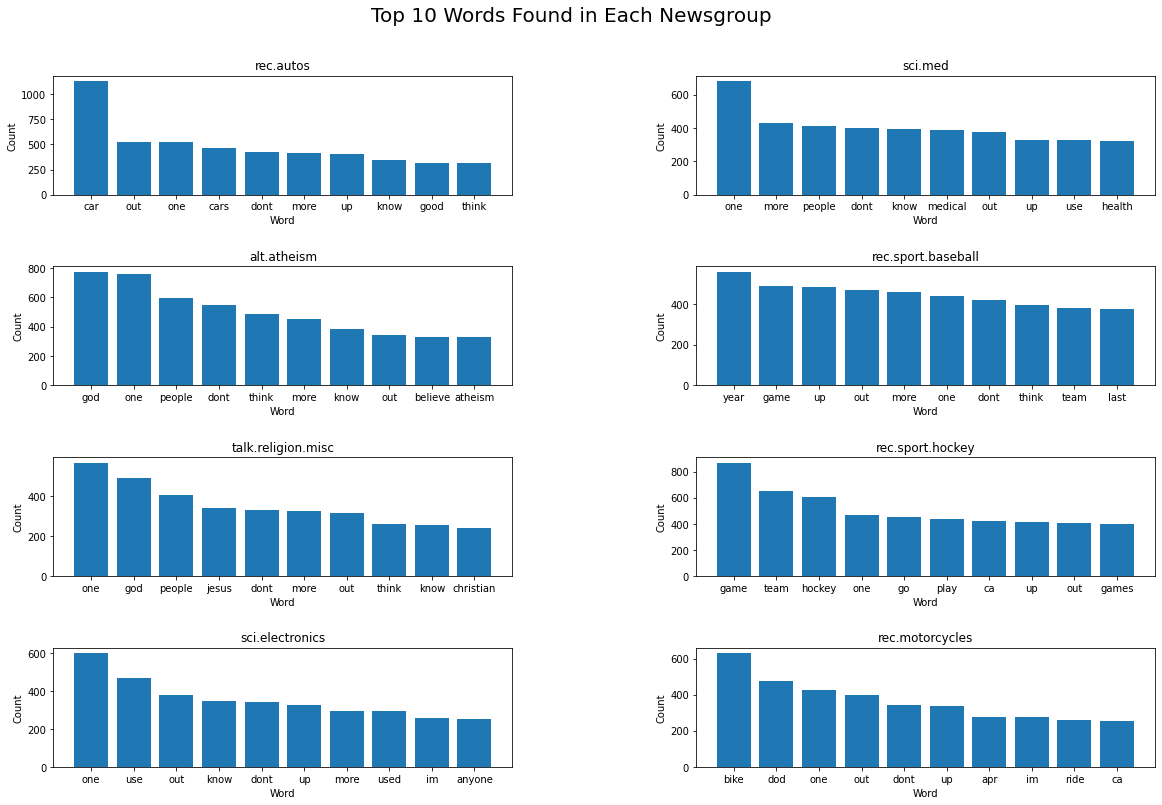

In [241]:
# code same as above, adjusted for newsgroups
fig = plt.figure(figsize = (18, 12))
fig.suptitle("Top 10 Words Found in Each Newsgroup", fontsize=20)
k = 1
for name in newsgroup_names:
    plot_wc_hist(wc_newsgroups, 10, name, fig, k)
    k += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)
plt.show()

#### Observations
There are words that are present in the top words of all, or most of, the newsgroups, such as "one", "dont", "know", and "out". This is to be expected because there are words and phrases that are really common, for example the phrase "I don't know".

What is important to note is that there are some unique words present in some newsgroups that aren't present in other ones. For example, "medical" and "health" were found very frequently in ```sci.med```, but doesn't up in the top ten words of any other newsgroup. Likewise, "jesus" and "christian" show up in ```talk.religion.misc```, but don't show up as often anywhere else except potentially ```alt.atheism```.

### Accuracy
To examine accuracy we will be using a standard split<sup>8</sup> of $80$% training data and $20$% test data for both datasets. As mentioned previously, we will be using F1 scores to measure accuracy. For the movie reviews, we will have a single F1 score as we are doing binary classification in this case. On the other hand, we will have $9$ F1 scores for the newsgroups dataset, one for each of the newsgroups because we are doing multi-class classification for this dataset and a weighted F1 score that is a weighted average of the eight scores.

In theory, it would be expected that the classifier performs better on binary classification than multi-class classification because having more classes increases the likelihood of misclassification (i.e., more classes means more possibilities to be incorrect).

However, in practice this may not be the case. As we have observed from the previous section, $7$ of the top $10$ "positive" words are also found in the top $10$ "negative" words, which is a problem because we would like for the words to be unique to each category.

For the newsgroup dataset, the F1 scores of some newsgroups should be very high while others are lower. In particular, if the newsgroups are similar, then they will most likely be misclassified. For example, there is a newsgroup for miscellaneous religious talk and a newsgroup for atheism -- it is clear that both have to do with religion. There are also very unique newsgroups, such as the medical and electronics ones, where it should be expected that the scores for these groups are very high as medical and electronics terminologies should not be appearing in other types of posts as frequently.

This is what we found when we compared the top $10$ words found in each newsgroup category: there was a overlap in newsgroups that were similar and for categories that were unique, there were words in their top $10$ that did not appear in any other categories.


In [242]:
test_movies["clean_text"] = test_movies["review"].apply(clean_movies, stopwords = sw)
test_news["clean_text"] = test_news["cleaned_words"].str.join(" ")

In [248]:
# Run classifier on the test set - movies
# on average 6-7 iterations per seconds => approx 13 minutes to train on 5000 samples (80/20 split)
l1 = [k for k in range(test_movies.shape[0])]
sentiment_pred = np.array([NB_classifier(test_movies.iloc[k]["clean_text"], word_counts = wc_movies, stopwords = sw) for k in tqdm(l1, position=0, leave=True)])

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [15:06<00:00,  5.51it/s]
<ipython-input-248-9971028c2986>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentiment_pred = np.array([NB_classifier(test_movies.iloc[k]["clean_text"], word_counts = wc_movies, stopwords = sw) for k in tqdm(l1, position=0, leave=True)])


In [256]:
# map "positive" to 1 and "negative" to 0
predicted_sentiment = np.array([1 if k == "positive" else 0 for k in [sentiment_pred[n][0] for n in range(len(sentiment_pred))]])
actual_sentiment = np.array([1 if k == "positive" else 0 for k in test_movies["sentiment"]])

In [257]:
# calculate f1 score
print(f"Movie Reviews: {f1_score(actual_sentiment, predicted_sentiment)}")

Movie Reviews: 0.8460111317254175


In [243]:
# Run classifier on the test set - newsgroups
# on average 6-7 iterations per seconds => approx 5 minutes to train on 1393 samples (80/20 split)
l2 = [k for k in range(test_news.shape[0])]
news_pred = np.array([NB_classifier(test_news.iloc[k]["clean_text"], word_counts = wc_newsgroups, stopwords = sw) for k in tqdm(l2, position=0, leave=True)])

100%|██████████████████████████████████████████████████████████████████████████████| 1393/1393 [06:28<00:00,  3.58it/s]
<ipython-input-243-cdfc9617176d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  news_pred = np.array([NB_classifier(test_news.iloc[k]["clean_text"], word_counts = wc_newsgroups, stopwords = sw) for k in tqdm(l2, position=0, leave=True)])


In [258]:
# create array of predictions
predicted_newsgroup = np.array([news_pred[n][0] for n in range(len(news_pred))])
actual_newsgroup = np.array(test_news["newsgroup"])

In [259]:
# calculate f1 scores
print(f"Per-class:\n {f1_score(actual_newsgroup, predicted_newsgroup, average = None)}")
print(f"Weighted:\n {f1_score(actual_newsgroup, predicted_newsgroup, average = 'weighted')}")

Per-class:
 [0.86567164 0.94339623 0.95953757 0.95108696 0.97172237 0.95263158
 0.95212766 0.79638009]
Weighted:
 0.9312246803015516


f1 scores for Movie Reviews: 0.8460111317254175


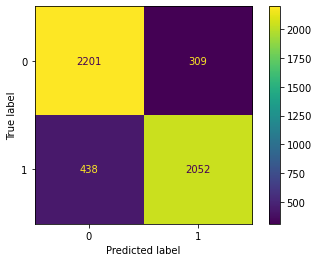

In [260]:
print(f"f1 scores for Movie Reviews: {f1_score(actual_sentiment, predicted_sentiment)}")
ConfusionMatrixDisplay.from_predictions(actual_sentiment, predicted_sentiment)
plt.show()

Per-class f1 scores for Newsgroups:
[0.86567164 0.94339623 0.95953757 0.95108696 0.97172237 0.95263158
 0.95212766 0.79638009]
Weighted f1 score for Newsgroups:
0.9312246803015516


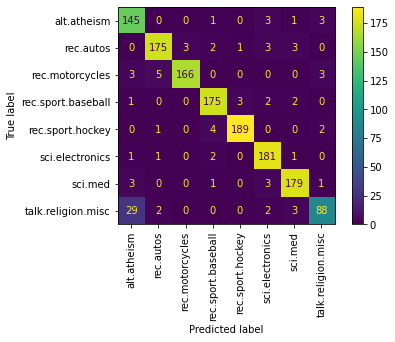

In [261]:
print(f"Per-class f1 scores for Newsgroups:\n{f1_score(actual_newsgroup, predicted_newsgroup, average = None)}")
print(f"Weighted f1 score for Newsgroups:\n{f1_score(actual_newsgroup, predicted_newsgroup, average = 'weighted')}")
ConfusionMatrixDisplay.from_predictions(actual_newsgroup, predicted_newsgroup, xticks_rotation = "vertical")
plt.show()

#### Discussion of Results
Running the classifier on our review test set, we obtained a F1 score of about $0.8460$, which is pretty good considering the variety in the reviews.

On the newsgroups test set, we obtained a weighted F1 score of about $0.9312$, which is much better than we would have expected for multi-class classification. In fact, this is quite a bit better than the performance on reviews, which may suggest that our hypothesis that the most frequent words used in both types of movie reviews are too similar, to be true.

The F1 scores of each category, rounded to 4 decimal places, are as follows:


```alt.atheism```: $0.8657$,<br>
```rec.autos```: $0.9434$,<br>
```rec.motorcycles```: $0.9595$,<br>
```rec.sport.baseball```: $0.9511$,<br>
```rec.sport.hockey```: $0.9717$,<br>
```sci.electronics```: $0.9526$,<br>
```sci.med```: $0.9521$,<br>
```talk.religion.misc```: $0.7964$

These results are very much in line with what we expected. ```alt.atheism``` and ```talk.religion.misc```, which both had "god" as one of their top words, tended to be misclassified more than the other newsgroups hence their relatively low scores. From the confusion matrix, it can be seen that when the true label was ```talk.religion.misc```, the text was misclassified as ```alt.atheism``` $29$ times, the most of any other newsgroup.

### Efficiency: Observed Runtime
Using ```tqdm```'s progress bar, we can observe that our function, ```NB_classifier```, runs between $6$ and $7$ iterations per second on average.

### Efficiency: Asymptotic Runtime
For this section, we will determine the asymptotic runtime of the main parts of our implementation using Big-O notation, which is just a statement of an upper-bound on the runtime of an algorithm (disregarding coefficients) at very large inputs. As an example, $O(n)$ means that an algorithm scales linearly with input size and $O(1)$ means an algorithm runs in constant time (i.e., input size doesn't contribute to runtime).

By a quick inspection of our code, we mainly use ```numpy``` and built-in Python methods. In general, ```numpy``` operations are optimized for speed so we can assume the operations we used in ```NB_classifier``` are $O(1)$ on average or amortized $O(n)$, thus the runtime scales linearly with how many words are in the piece of text we want to classify and how many possible categories there are.

So, let the number of words be denoted by $n$ and the number of possible categories be $c$: the runtime is $O(nc)$.

We obtain the word counts by looping through the rows of our dataframe and then looping through the words in each text entry. Taking a look at the code we used:

```python
word_counts_newsgroups = {}
for row in train_news.itertuples():
    ng = row.newsgroup
    for word in row.cleaned_words:
        if word not in word_counts_newsgroups:
            word_counts_newsgroups[word] = {
                'rec.autos': 0, 'sci.med': 0, 'alt.atheism': 0,
                'rec.sport.baseball': 0, 'talk.religion.misc': 0,
                'rec.sport.hockey': 0, 'sci.electronics': 0,
                'rec.motorcycles': 0
            }
        word_counts_newsgroups.get(word)[ng] += 1
```

If we let the number of rows be $m$ and the number of words in a given row be $k$, then this entire code block has a runtime of $O(mk)$, since ```dict.get``` and adding to a dictionary are both $O(1)$ on average.<sup>5</sup>

In conclusion, our implementation is $O(nc) + O(mk)$, where:
* $n$: the number of words in the text to classify
* $c$: the number of possible categories
* $m$: the size of our training set
* $k$: the number of words in our training set

If we consider that we are only using ```NB.classifier``` multiple times on a dataset, then the amortized runtime of this algorithm must be $O(nc)$, as we compute word counts only once per training set.

### Varying Training Size
In this section, we analyze how well our classifier does depending on the size of the training set, measured by increases in accuracy. We would also like to determine how marginal these increases are.

As discussed in the previous section, our algorithm scales linearly with the size of our training set and the number of words in the target text. For very large datasets that may have millions of entries, the computation of word counts can become significant even though it is only done once. So, if the increase in accuracy is highly marginal between changes in training set size, this begs the question of whether using such a large training set is worth it if the increase in accuracy is small and the trade-off is a longer computation time for word counts.

For example, let's say at an $80-20$ split we obtain a F1 score of $0.84$, and at a $50-50$ split we obtain a F1 score of $0.82$. And let's say our complete data set has $2.5$ million rows; for the former case we have a training set size of $2$ million and for the latter we have a size of $1.25$ million. Although this example is a little exaggerated, our hypothetical results suggest that adding in $750000$ more data points barely increases the accuracy, which may lead to the $50-50$ split being more favored as it is not as computationally expensive to compute the word counts.

With this as our motivation, we will vary training size until we see marginal improvement in F1 scores. Since the classifier did not perform as well as we would have hoped for the movie reviews, this is the dataset we want to investigate and assume that the results generalize to the newsgroup dataset as well.

In [39]:
# Setting up word count dicts

# try 80-20
train_movies_80, test_movies_20 = train_test_split(movie_reviews, train_size = 0.80, random_state = 105)
train_movies_80["cleaned_words"] = train_movies_80["review"].apply(clean_movies, stopwords = sw).str.split()

# word counts for 80-20, code same as above
word_counts_movies_80 = {}
for row in train_movies_80.itertuples():
    sentiment = row.sentiment
    for word in row.cleaned_words:
        if word not in word_counts_movies_80:
            word_counts_movies_80[word] = {"positive": 0, "negative": 0}
        word_counts_movies_80.get(word)[sentiment] += 1

wc_movies_80 = pd.DataFrame.from_dict(word_counts_movies_80, orient='index')
wc_movies_80 = wc_movies_80[['positive', 'negative']]

# try 60-40
train_movies_60, test_movies_40 = train_test_split(movie_reviews, train_size = 0.60, random_state = 105)
train_movies_60["cleaned_words"] = train_movies_60["review"].apply(clean_movies, stopwords = sw).str.split()

# word counts for 60-40, code same as above
word_counts_movies_60 = {}
for row in train_movies_60.itertuples():
    sentiment = row.sentiment
    for word in row.cleaned_words:
        if word not in word_counts_movies_60:
            word_counts_movies_60[word] = {"positive": 0, "negative": 0}
        word_counts_movies_60.get(word)[sentiment] += 1

wc_movies_60 = pd.DataFrame.from_dict(word_counts_movies_60, orient='index')
wc_movies_60 = wc_movies_60[['positive', 'negative']]

# try 90-10
train_movies_90, test_movies_10 = train_test_split(movie_reviews, train_size = 0.90, random_state = 105)
train_movies_90["cleaned_words"] = train_movies_90["review"].apply(clean_movies, stopwords = sw).str.split()

# word counts for 90-10, code same as above
word_counts_movies_90 = {}
for row in train_movies_90.itertuples():
    sentiment = row.sentiment
    for word in row.cleaned_words:
        if word not in word_counts_movies_90:
            word_counts_movies_90[word] = {"positive": 0, "negative": 0}
        word_counts_movies_90.get(word)[sentiment] += 1

wc_movies_90 = pd.DataFrame.from_dict(word_counts_movies_90, orient='index')
wc_movies_90 = wc_movies_90[['positive', 'negative']]

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:20<00:00,  7.35it/s]
<ipython-input-40-d731e4bae7d3>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_20 = np.array([NB_classifier(test_movies_20.iloc[k]["clean_text"],


f1 scores for Movie Reviews: 0.8580844490216272


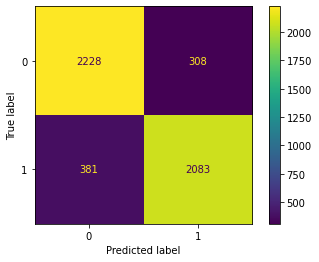

In [40]:
# test on 80-20
test_movies_20["clean_text"] = test_movies_20["review"].apply(clean_movies, stopwords = sw)
l3 = [k for k in range(test_movies_20.shape[0])]
y_20 = np.array([NB_classifier(test_movies_20.iloc[k]["clean_text"],
                               word_counts = wc_movies_80, stopwords = sw) for k in tqdm(l3, position=0, leave=True)])

p_sentiment_8020 = np.array([1 if k == "positive" else 0 for k in [y_20[n][0] for n in range(len(y_20))]])
a_sentiment_8020 = np.array([1 if k == "positive" else 0 for k in test_movies_20["sentiment"]])

print(f"f1 scores for Movie Reviews: {f1_score(a_sentiment_8020, p_sentiment_8020)}")
ConfusionMatrixDisplay.from_predictions(a_sentiment_8020, p_sentiment_8020)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [25:49<00:00,  6.45it/s]
<ipython-input-38-158af9fcbd95>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_40 = np.array([NB_classifier(test_movies_40.iloc[k]["clean_text"],


f1 scores for Movie Reviews: 0.8529198966408268


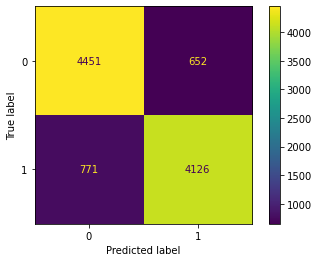

In [38]:
# test on 60-40
test_movies_40["clean_text"] = test_movies_40["review"].apply(clean_movies, stopwords = sw)
l4 = [k for k in range(test_movies_40.shape[0])]
y_40 = np.array([NB_classifier(test_movies_40.iloc[k]["clean_text"],
                               word_counts = wc_movies_60, stopwords = sw) for k in tqdm(l4, position=0, leave=True)])

p_sentiment_6040 = np.array([1 if k == "positive" else 0 for k in [y_40[n][0] for n in range(len(y_40))]])
a_sentiment_6040 = np.array([1 if k == "positive" else 0 for k in test_movies_40["sentiment"]])

print(f"f1 scores for Movie Reviews: {f1_score(a_sentiment_6040, p_sentiment_6040)}")
ConfusionMatrixDisplay.from_predictions(a_sentiment_6040, p_sentiment_6040)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [05:53<00:00,  7.07it/s]
<ipython-input-41-ddf90856a531>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_10 = np.array([NB_classifier(test_movies_10.iloc[k]["clean_text"],


f1 scores for Movie Reviews: 0.8578491965389369


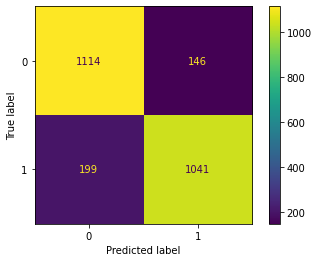

In [41]:
# test on 90-10
test_movies_10["clean_text"] = test_movies_10["review"].apply(clean_movies, stopwords = sw)
l5 = [k for k in range(test_movies_10.shape[0])]
y_10 = np.array([NB_classifier(test_movies_10.iloc[k]["clean_text"],
                               word_counts = wc_movies_90, stopwords = sw) for k in tqdm(l5, position=0, leave=True)])

p_sentiment_9010 = np.array([1 if k == "positive" else 0 for k in [y_10[n][0] for n in range(len(y_10))]])
a_sentiment_9010 = np.array([1 if k == "positive" else 0 for k in test_movies_10["sentiment"]])

print(f"f1 scores for Movie Reviews: {f1_score(a_sentiment_9010, p_sentiment_9010)}")
ConfusionMatrixDisplay.from_predictions(a_sentiment_9010, p_sentiment_9010)
plt.show()

In [42]:
results = {"60" : f1_score(a_sentiment_6040, p_sentiment_6040),
           "80" : f1_score(a_sentiment_8020, p_sentiment_8020),
           "90" : f1_score(a_sentiment_9010, p_sentiment_9010)}

print(results)

{'60': 0.8529198966408268, '80': 0.8580844490216272, '90': 0.8578491965389369}


#### Discussion of Results
For these specific splits of training and test data, the results we have obtained seem to support the idea that increasing training set size only marginally increases performance of the classifier. The F1 scores we obtained are $0.8529$, $0.8581$. and $0.8578$ for the training splits of $60$, $80$, and $90$ percent, respectively.

Although there was an increase in accuracy between $60$ and $80$ percent, it was a very small increase in performance relative to the increase in training set size. For $80$ and $90$ percent, it is safe to say that the result was pretty much the same - there was a decrease in accuracy but this may have just been due to the data included in either split.

We can conclude that, for much larger data sets of movie reviews, it might be more reasonable to train using a $60-40$ split if training time is a concern.

## Conclusions
In this project, we implemented a Multinomial Naive Bayes Classifier and tested various aspects of its performance using two different sets of text data. The first, and arguably more difficult, part of this project was to pre-process and clean the data sets. The movie reviews were already in a tabular format with each row representing a review and corresponding sentiment, while the newsgroups were in a singular text file that required much more processing. During this step of processing the newsgroups file, we made the important choice to filter out incomplete entries: any posts that did not have a newsgroup, author, or subject.

We then had to "clean" the data to make each text entry standardized so variation in text could be minimized.

Once all of the pre-processing was done, our tests generally suggested that the classifier performed better on classifiying most newsgroups than movie reviews, which ran contrary to our theoretical expectation of the classifier performing better on binary classification than multiclass classification problems, but were more in line with our expectations after observing that many of the most frequent words in ```positive``` reviews were similarly frequent in ```negative``` reviews.

Posts from ```talk.religion.misc``` were misclassified as ```alt.atheism``` more often than other newsgroups were misclassified, but as we said previously this is most likely due to how closely related the two topics are (so the most frequent words in both categories could be very similar).

We also found that increasing the size of our training data led to marginal improvements, at least between a $60-40$ split and an $80-20$ split, so if people are concerned about time it may be more beneficial to use a smaller training set split and see if accuracy is still high.

In regards to other areas of exploration, we should observe the classifier's performance on other binary and multiclass text classification problems and compare their results to determine if the classifier is, in general, more accurate for putting text into two categories than more than two categories. We also want to test other kinds of text besides movie reviews and forum posts, so for example we could look at problems involving tweet sentiment, email spam, or customer support tickets.

To improve results, we could see if (and where) the cleaning of our text data fell short and fix up those areas. The accuracy of any classifier when dealing with text classification problems is highly dependent on the data being well-formatted. One of the biggest things we did not do was lemmatization,<sup>6</sup> which is considering the context of the word and turning a word into its base form. For example, "running" would turn into "run" and "caring" would turn into "care". This part of the cleaning process combines words that are essentially the same word by transforming them into their base form.

Finally, the biggest drawback of the Naive Bayes Classifier is its assumption that every predictor is independent of every other predictor which is why it is "naive". In the case where this assumption is true, the classifier produces very accurate probabilities, but if the assumption is false then the probabilities break down and cannot be trusted for accuracy. For example, if we are trying to predict having a heart attack based on high blood pressure and previously having a stroke, then we know that the predictors (high blood pressure, stroke history) are not independent because high blood pressure is a factor in having a stroke. In cases such as this, it might be better to use other classifiers or prediction methods.

## References

1. Naive Bayes Documentation. scikit-learn. Accessed from https://scikit-learn.org/stable/modules/naive_bayes.html, on April, 06, 2023.

2. Bayes' Theorem. Wikipedia. Accessed from https://en.wikipedia.org/wiki/Bayes%27_theorem, on April 06. 2023.

3. Gaussian vs Multinomial vs Bernoulli Naive Bayes. MyGreatLearning. Accessed from https://www.mygreatlearning.com/blog/multinomial-naive-bayes-explained/#difference-between-bernoulli-multinomial-and-gaussian-naive-bayes, on April 09, 2023.

4. A Look at Precision, Recall, and F1-Score. TowardsDataScience. Accessed from https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec, on April 08, 2023.

5. Time Complexity. Python Wiki. Accessed from https://wiki.python.org/moin/TimeComplexity, on April 11, 2023.

6. Tokenization and Normalization. Analytics Vidhya. Accessed from https://www.analyticsvidhya.com/blog/2021/03/tokenization-and-text-normalization/, on April 11, 2023.

7. Laplace Smoothing in Naive Bayes Algorithm. Towards Data Science. Accessed from https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece, on April 11, 2023.

8. Train-Test Split for Evaluating Machine Learning Algorithms. Machine Learning Mastery. Accessed from https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/, on April 11, 2023.